#### Pretrained models are from: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md
#### Tutorial on deeplabv3+ : https://towardsdatascience.com/semantic-segmentation-of-150-classes-of-objects-with-5-lines-of-code-7f244fa96b6c
#### tutorial on ADE20k with tensorflow: https://colab.research.google.com/github/dhassault/tf-semantic-example/blob/master/01b_semantic_segmentation_basic_colab.ipynb#scrollTo=LaPKA60VTUX9

In [ ]:
#!pip install gensim==3.4.0

# Importing libraries

In [1]:
import pixellib
from pixellib.semantic import semantic_segmentation
#from pixellib.custom_train import instance_custom_training

In [2]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa


AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.6.2


# Creating variables

In [3]:
# Convert Checkpoint to model
cpk_path = "models/pretrained/deeplabv3_xception65_ade20k_train/" #frozen_inference_graph.pb
root = "gluonCV/"
dataset_path = root + "ADEChallengeData2016/images/"
training_data = "training/"
val_data = "validation/"
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 151
SEED = 26

# Creating a source dataset

In [5]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 20210 images.
The Validation Dataset contains 2000 images.


## Helper functions

In [9]:
import gensim.downloader as api
import gensim

# Load a pre-trained Word2Vec model (for example, 'word2vec-google-news-300')
print("loading model")
word2vec_model = api.load("word2vec-google-news-300")
print("word2vec_model loaded")

loading model
word2vec_model loaded


In [59]:
class_name_mapping["ADE_train_00003870"]

'bedroom'

In [215]:
scene_categories_file = 'gluonCV/ADEChallengeData2016/sceneCategories.txt'
class_name_mapping = {}

with open(scene_categories_file, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            image_file_name, class_name = parts
            class_name_mapping[image_file_name] = class_name
            

def get_word_embedding(class_name):
    """
    Get the Word2Vec embedding for the given class name using tf.py_function.
    If the class name is not in the model's vocabulary, try individual words,
    or return a zero vector as a fallback.
    """
    def _get_embedding(class_name):
        class_name_str = class_name.numpy().decode('utf-8').replace("_", " ")
        #print("classname: ", class_name_str)
        words = class_name_str.split()

        try:
            return word2vec_model[class_name_str]
        except KeyError:
            word_embeddings = []
            for word in words:
                try:
                    word_embeddings.append(word2vec_model[word])
                except KeyError:
                    continue

            if word_embeddings:
                return np.mean(word_embeddings, axis=0)
            else:
                return np.zeros(word2vec_model.vector_size)

    # Wrap the Python function with tf.py_function
    return tf.py_function(_get_embedding, [class_name], Tout=tf.float32)



def remove_duplicates(batch):
    unique_class_names = tf.unique(batch['class_name']).y

    return filtered_batch

def parse_image(img_path):
    """
    Load an image and its annotation (mask), and return a dictionary
    including the image, the segmentation mask, and the Word2Vec embedding
    of the class name.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Extract the base file name and look up the class name from the mapping
    file_name = tf.strings.split(tf.strings.split(img_path, os.sep)[-1], '.')[0]
    
    # Debugging: Print the file name
    #tf.print("File name:", file_name)
    
    file_identifier = tf.strings.split(file_name, '_')[:-1]  # Adjust this according to your filename format
    file_identifier = tf.strings.reduce_join(file_identifier, separator='_')
    
    #print("file_identifier : ", file_identifier)


    class_name_tensor = tf.py_function(
        func=lambda x: class_name_mapping.get(x.numpy().decode('utf-8'), 'unknown'),
        inp=[file_name],  # Use file_name directly
        Tout=tf.string
    )
    
    #print("class_name_tensor : ", class_name_tensor)

    word_embedding = get_word_embedding(class_name_tensor)

    # Construct mask path and load mask
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)


    return {'image': image, 'word_embedding': word_embedding, 'class_name': class_name_tensor, 'segmentation_mask': mask}


embedding = get_word_embedding("living_room")
print(embedding)  

tf.Tensor(
[ 0.07952881  0.11962891 -0.05053711  0.13696289  0.06542969  0.15136719
  0.01123047 -0.05487061  0.09054565  0.08972168 -0.06628418 -0.14160156
 -0.02636719 -0.08898926 -0.08630371 -0.1730957   0.19677734  0.13574219
  0.01855469  0.10327148  0.13293457 -0.02636719 -0.10134888 -0.14990234
 -0.0859375  -0.11352539 -0.21386719  0.05096436  0.00735474 -0.15673828
 -0.15625    -0.05334473 -0.08996582  0.05548096 -0.2553711  -0.29003906
  0.09356689 -0.00878906 -0.12866211  0.02490234 -0.1953125   0.06488037
  0.07885742  0.12158203  0.08666992  0.01425171 -0.13401794  0.08172607
 -0.16394043 -0.0668602   0.01147461 -0.09399414  0.09332275 -0.1743164
 -0.05438232 -0.2919922  -0.01025391  0.034729    0.10131836  0.01850891
  0.14379883  0.17626953 -0.09063721 -0.04736328  0.06787109  0.02600098
  0.10986328  0.19042969 -0.11962891 -0.02536011  0.11791992  0.05566406
  0.14709473  0.06567383 -0.12792969 -0.01647949  0.00927734 -0.02600098
 -0.00952148  0.20263672  0.12109375  0.0

## Loading dataset

In [216]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

In [217]:
for batch in train_dataset.take(10):  # Take 1 batch from the dataset
    class_names = batch['class_name']
    print("Batch class names:", class_names.numpy())  # Convert tensor to numpy array for printing


Batch class names: b'roundabout'
Batch class names: b'bedroom'
Batch class names: b'street'
Batch class names: b'ruin'
Batch class names: b'bathhouse_outdoor'
Batch class names: b'nursery'
Batch class names: b'operating_room'
Batch class names: b'home_office'
Batch class names: b'movie_theater_indoor'
Batch class names: b'airport_terminal'


## Applying some transformations to our dataset

In [72]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    def f1(): return tf.image.flip_left_right(input_image), tf.image.flip_left_right(input_mask)
    def f2(): return input_image, input_mask

    input_image, input_mask = tf.cond(tf.random.uniform(()) > 0.5, f1, f2)

    return {'image': input_image, 'segmentation_mask': input_mask, 'word_embedding': datapoint['word_embedding'], 'class_name': datapoint['class_name']}


@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation."""
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # Normalize the images and masks
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0

    return {'image': input_image, 'segmentation_mask': input_mask, 'word_embedding': datapoint['word_embedding'], 'class_name': datapoint['class_name']}


In [73]:
BATCH_SIZE = 5

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: {image: (None, 128, 128, 3), segmentation_mask: (None, 128, 128, 1), word_embedding: <unknown>, class_name: <unknown>}, types: {image: tf.float32, segmentation_mask: tf.float32, word_embedding: tf.float32, class_name: tf.string}>
<PrefetchDataset shapes: {image: (None, 128, 128, 3), segmentation_mask: (None, 128, 128, 1), word_embedding: <unknown>, class_name: <unknown>}, types: {image: tf.float32, segmentation_mask: tf.float32, word_embedding: tf.float32, class_name: tf.string}>


## Visualizing a sample

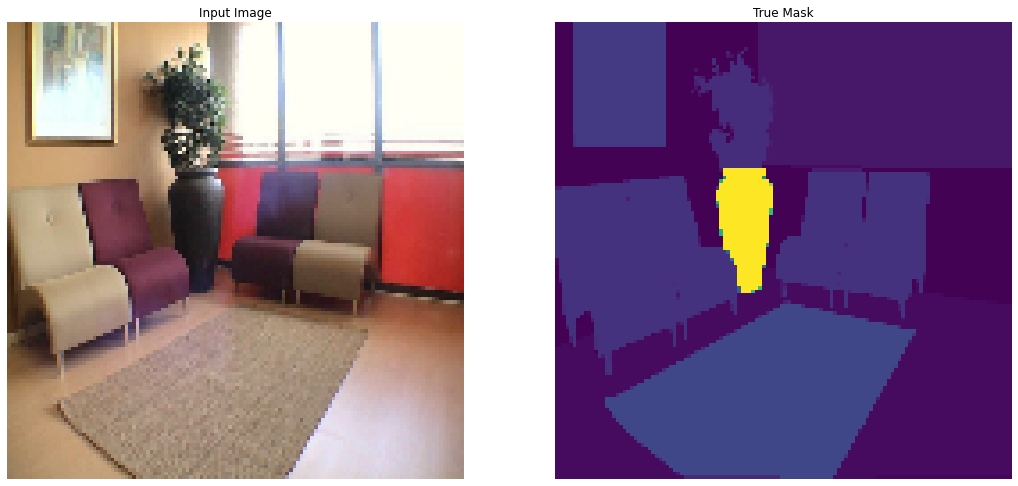

[[ 0.0458374   0.11816406  0.10400391 ...  0.16967773 -0.09033203
   0.04672241]
 [-0.18017578  0.08947754  0.11462402 ...  0.20898438 -0.15673828
  -0.02972412]
 [ 0.30859375  0.02832031  0.109375   ...  0.00457764  0.33203125
  -0.21777344]
 [-0.11669922 -0.07861328 -0.13574219 ... -0.28125    -0.25585938
   0.16015625]
 [ 0.16796875 -0.16113281 -0.02368164 ... -0.08740234  0.12695312
   0.19238281]]
class_name:  [b'waiting_room' b'jacuzzi_indoor' b'highway' b'misc' b'bedroom']
(128, 128, 3)
(300,)
(128, 128, 1)


In [75]:
def display_sample(display_list, class_name=None):
    """Show side-by-side an input image, the ground truth and the prediction."""
    plt.figure(figsize=(18, 18))

    titles = ['Input Image', 'True Mask', 'Prediction']
    if class_name is not None:
        titles.append(f'Class: {class_name}')

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for data in dataset['train'].take(1):
    sample_image = data['image'][0]
    sample_mask = data['segmentation_mask'][0]
    sample_embedding = data['word_embedding'][0]
    class_name = data['class_name'].numpy()#.decode('utf-8')  # Decode class name from tensor to string
    display_sample([sample_image, sample_mask], class_name)
    
print(data['word_embedding'].numpy())
#class_name = class_name_mapping[class_name.replace("b'", "'")]
print("class_name: ", class_name)

print(np.shape(sample_image))
print(np.shape(sample_embedding))
print(np.shape(sample_mask))

# Making it suitable for Zero Shot Problem

In [201]:
class_mapping = {
    1: "wall",
    2: "building, edifice",
    3: "sky",
    4: "floor, flooring",
    5: "tree",
    6: "ceiling",
    7: "road, route",
    8: "bed",
    9: "windowpane, window",
    10: "grass",
    11: "cabinet",
    12: "sidewalk, pavement",
    13: "person, individual, someone, somebody, mortal, soul",
    14: "earth, ground",
    15: "door, double door",
    16: "table",
    17: "mountain, mount",
    18: "plant, flora, plant life",
    19: "curtain, drape, drapery, mantle, pall",
    20: "chair",
    21: "car, auto, automobile, machine, motorcar",
    22: "water",
    23: "painting, picture",
    24: "sofa, couch, lounge",
    25: "shelf",
    26: "house",
    27: "sea",
    28: "mirror",
    29: "rug, carpet, carpeting",
    30: "field",
    31: "armchair",
    32: "seat",
    33: "fence, fencing",
    34: "desk",
    35: "rock, stone",
    36: "wardrobe, closet, press",
    37: "lamp",
    38: "bathtub, bathing tub, bath, tub",
    39: "railing, rail",
    40: "cushion",
    41: "base, pedestal, stand",
    42: "box",
    43: "column, pillar",
    44: "signboard, sign",
    45: "chest of drawers, chest, bureau, dresser",
    46: "counter",
    47: "sand",
    48: "sink",
    49: "skyscraper",
    50: "fireplace, hearth, open fireplace",
    51: "refrigerator, icebox",
    52: "grandstand, covered stand",
    53: "path",
    54: "stairs, steps",
    55: "runway",
    56: "case, display case, showcase, vitrine",
    57: "pool table, billiard table, snooker table",
    58: "pillow",
    59: "screen door, screen",
    60: "stairway, staircase",
    61: "river",
    62: "bridge, span",
    63: "bookcase",
    64: "blind, screen",
    65: "coffee table, cocktail table",
    66: "toilet, can, commode, crapper, pot, potty, stool, throne",
    67: "flower",
    68: "book",
    69: "hill",
    70: "bench",
    71: "countertop",
    72: "stove, kitchen stove, range, kitchen range, cooking stove",
    73: "palm, palm tree",
    74: "kitchen island",
    75: "computer, computing machine, computing device, data processor, electronic computer, information processing system",
    76: "swivel chair",
    77: "boat",
    78: "bar",
    79: "arcade machine",
    80: "hovel, hut, hutch, shack, shanty",
    81: "bus, autobus, coach, charabanc, double-decker, jitney, motorbus, motorcoach, omnibus, passenger vehicle",
    82: "towel",
    83: "light, light source",
    84: "truck, motortruck",
    85: "tower",
    86: "chandelier, pendant, pendent",
    87: "awning, sunshade, sunblind",
    88: "streetlight, street lamp",
    89: "booth, cubicle, stall, kiosk",
    90: "television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box",
    91: "airplane, aeroplane, plane",
    92: "dirt track",
    93: "apparel, wearing apparel, dress, clothes",
    94: "pole",
    95: "land, ground, soil",
    96: "bannister, banister, balustrade, balusters, handrail",
    97: "escalator, moving staircase, moving stairway",
    98: "ottoman, pouf, pouffe, puff, hassock",
    99: "bottle",
    100: "buffet, counter, sideboard",
    101: "poster, posting, placard, notice, bill, card",
    102: "stage",
    103: "van",
    104: "ship",
    105: "fountain",
    106: "conveyer belt, conveyor belt, conveyer, conveyor, transporter",
    107: "canopy",
    108: "washer, automatic washer, washing machine",
    109: "plaything, toy",
    110: "swimming pool, swimming bath, natatorium",
    111: "stool",
    112: "barrel, cask",
    113: "basket, handbasket",
    114: "waterfall, falls",
    115: "tent, collapsible shelter",
    116: "bag",
    117: "minibike, motorbike",
    118: "cradle",
    119: "oven",
    120: "ball",
    121: "food, solid food",
    122: "step, stair",
    123: "tank, storage tank",
    124: "trade name, brand name, brand, marque",
    125: "microwave, microwave oven",
    126: "pot, flowerpot",
    127: "animal, animate being, beast, brute, creature, fauna",
    128: "bicycle, bike, wheel, cycle",
    129: "lake",
    130: "dishwasher, dish washer, dishwashing machine",
    131: "screen, silver screen, projection screen",
    132: "blanket, cover",
    133: "sculpture",
    134: "hood, exhaust hood",
    135: "sconce",
    136: "vase",
    137: "traffic light, traffic signal, stoplight",
    138: "tray",
    139: "ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin",
    140: "fan",
    141: "pier, wharf, wharfage, dock",
    142: "crt screen",
    143: "plate",
    144: "monitor, monitoring device",
    145: "bulletin board, notice board",
    146: "shower",
    147: "radiator",
    148: "glass, drinking glass",
    149: "clock",
    150: "flag"
}


In [425]:
def prepare_for_model(data):
    # Resize image to match the expected input shape of the model
    resized_image = tf.image.resize(data['image'], (128, 128))

    # Prepare inputs dictionary
    inputs = {'input_1': resized_image, 'input_2': data['word_embedding']}

    # Initialize a new mask with all zeros
    num_classes = 10  # Total number of classes including background
    new_mask = tf.zeros((128, 128, num_classes), dtype=tf.float32)

    resized_mask = tf.image.resize(data['segmentation_mask'], (128, 128))

    # Find the unique values in the resized mask, excluding zero
    unique_values = tf.unique(tf.reshape(resized_mask, [-1]))[0]
    unique_values = tf.boolean_mask(unique_values, unique_values > 0)

    # Sort the unique values in descending order
    unique_values = tf.sort(unique_values, direction='DESCENDING')

    # Number of unique values
    num_unique_values = tf.shape(unique_values)[0]

    def update_mask(idx):
        # Get the value for this index
        value = unique_values[idx]
        class_mask = tf.cast(resized_mask[..., 0] == value, tf.float32)

        # Expand the dimensions of one_hot_mask to make it broadcastable
        one_hot_mask = tf.one_hot(indices=idx, depth=num_classes)
        one_hot_mask = tf.reshape(one_hot_mask, [1, 1, num_classes])

        # Element-wise multiplication
        return class_mask[..., tf.newaxis] * one_hot_mask

    # Use tf.map_fn to apply update_mask to each index
    masks = tf.map_fn(update_mask, tf.range(num_unique_values), dtype=tf.float32)

    # Sum over all masks to get the final mask
    new_mask = tf.reduce_sum(masks, axis=0)

    # Ensure the output shape matches the logits' shape
    outputs = new_mask

    return inputs, outputs




train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)



# Apply this transformation to your dataset
train_dataset = train_dataset.map(prepare_for_model).batch(BATCH_SIZE)
val_dataset = val_dataset.map(prepare_for_model).batch(BATCH_SIZE)

In [426]:
# Creating a mock dataset
def create_mock_data(num_classes=151, image_shape=(128, 128, 3)):
    # Random image
    image = tf.random.uniform(shape=image_shape, minval=0, maxval=255, dtype=tf.float32)

    # Random word embedding
    word_embedding = tf.random.uniform(shape=(300,), minval=0, maxval=1, dtype=tf.float32)

    # Random segmentation mask (1 channel, values from 0 to num_classes-1)
    segmentation_mask = tf.random.uniform(shape=(128, 128, 1), minval=0, maxval=num_classes, dtype=tf.int32)

    # Random class names (assuming 151 different classes)
    class_names = tf.random.uniform(shape=(num_classes,), minval=0, maxval=num_classes, dtype=tf.int32)
    class_names = tf.strings.as_string(class_names)

    data = {'image': image, 'word_embedding': word_embedding, 'segmentation_mask': segmentation_mask, 'class_name': class_names}

    return data

# Mock class mapping (for demonstration)
#class_mapping = {i: f'class_{i}' for i in range(151)}

# Create mock data
mock_data = create_mock_data()

# Test the function
inputs, outputs = prepare_for_model(mock_data)

# Check outputs
print(outputs.numpy().shape, np.unique(outputs.numpy()))  # Shape and unique values in the output mask


(128, 128, 10) [0. 1.]


# Creating our model

## new UNET model

In [427]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dense, Reshape, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf


# Define a function to create the Word2Vec branch
def create_word2vec_branch(input_shape):
    word_input = Input(shape=input_shape, name="input_2")
    # Process the word input with Word2Vec model and additional layers as needed
    word_features = Dense(128, activation='relu')(word_input)
    word_features = Dense(64, activation='relu')(word_features)
    # Flatten for concatenation with convolutional features
    word_features = Flatten()(word_features)
    return word_input, word_features

# Define a function to create the U-Net model with an additional input for the class name
def create_Unet_with_word2vec(w=IMG_SIZE, h=IMG_SIZE, channels=N_CHANNELS, word_input_shape=(300,)):  # Word2Vec typically uses 300-dimensional vectors
    input_size = (w, h, channels)
    initializer = 'he_normal'

    # -- Word2Vec Branch -- #
    word_input, word_features = create_word2vec_branch(word_input_shape)

    # -- Encoder -- #
    # Block encoder 1
    inputs = Input(shape=input_size, name="input_1")
    conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
    conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

    # Block encoder 2
    max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
    conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
    conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

    # Block  encoder 3
    max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
    conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
    conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

    # Block  encoder 4
    max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
    conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
    conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
    # -- Encoder -- #

    # ----------- #
    maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
    conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
    conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
    # ----------- #

    
    word_feature_upsampled = Reshape((w // 16, h // 16, -1))(word_features)  # Adjust the target shape as per your bottleneck features
    combined_features = concatenate([conv, word_feature_upsampled], axis=-1)
    
    # -- Dencoder -- #
    # Block decoder 1
    up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(combined_features))
    merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
    conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
    conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

    # Block decoder 2
    up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
    merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
    conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
    conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

    # Block decoder 3
    up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
    merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
    conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
    conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

    # Block decoder 4
    up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
    merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
    conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
    conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
    conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
    # -- Dencoder -- #


    output = Conv2D(10, 1, activation='sigmoid')(conv_dec_4) #sample_image
    
    # Create model
    model = Model(inputs=[inputs, word_input], outputs=output)
    return model

# Create the U-Net model with Word2Vec input
model = create_Unet_with_word2vec()
model.summary()


Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1152 (Conv2D)            (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1153 (Conv2D)            (None, 128, 128, 64) 36928       conv2d_1152[0][0]                
__________________________________________________________________________________________________
max_pooling2d_192 (MaxPooling2D (None, 64, 64, 64)   0           conv2d_1153[0][0]                
___________________________________________________________________________________________

# Compiling and quick test

In [428]:
LR = 0.001
model.compile(optimizer=Adam(learning_rate=LR), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [312]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predicitons
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    



### Results with untrained unet

class name:  tf.Tensor(b'motel', shape=(), dtype=string)


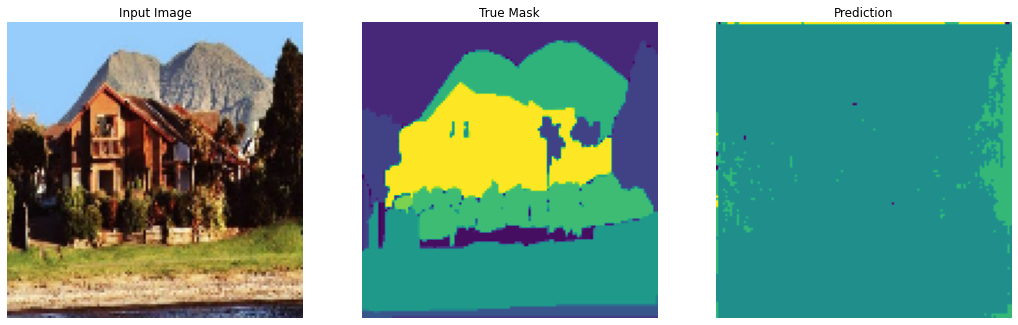

image[0] : (128, 128, 3)
sample_mask : (128, 128, 1)
create_mask(pred_mask) : (128, 128, 10)
(pred_mask) : (128, 128, 10)


In [429]:
def show_predictions(model=model, dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """

    for data in dataset.take(num):
        sample_image = data['image'][0]
        sample_mask = data['segmentation_mask'][0]
        sample_embedding = data['word_embedding'][0]
        sample_class_name = data['class_name'][0]
        
        word_embedding = np.expand_dims(sample_embedding, axis=0)  # Add batch dimension
        image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

        pred_mask = model.predict([image, word_embedding])[0]
        #print("pred_mask shape: ", np.shape(pred_mask), pred_mask)
        print("class name: ", sample_class_name)
        
        #pred_mask = model.predict(image)
        try:
            display_sample([image[0], (sample_mask), create_mask(pred_mask)])
            
        except:
            display_sample([image[0], sample_mask, (pred_mask)])
            
    print("image[0] :",np.shape(image[0]))
    print("sample_mask :",np.shape(sample_mask))
    print("create_mask(pred_mask) :",np.shape((pred_mask)))
    print("(pred_mask) :",np.shape((pred_mask)))
        
show_predictions(model, dataset['train'])

# Training our model

Segmentation Mask: (128, 128, 10)


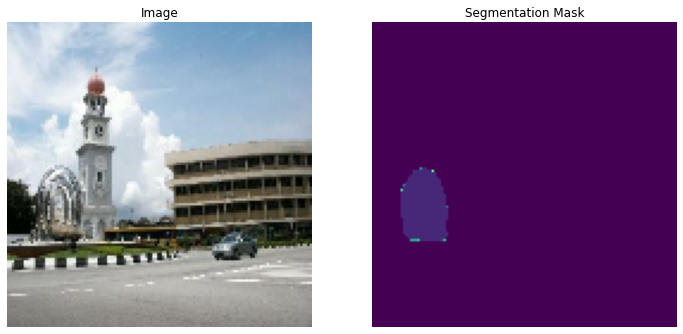

Sample Image:  (128, 128, 3)
Segmentation Mask: (128, 128, 10)
Word Embedding: (300,)
Channels with at least one row containing a 1: []
Uniques:  [0. 1.]


In [430]:
def find_channels_with_row_having_ones(arr):
    """
    Prints the indices of channels where any row across all images contains at least one '1'.
    :param arr: A 4D numpy array of shape (n, 128, 128, 151)
    """
    # Check if the array is in the expected shape
    if arr.shape[1:] != (128, 128, 151):
        raise ValueError("Array must be of shape (n, 128, 128, 151)")

    channels_with_ones = []

    # Iterate through each channel
    for channel in range(arr.shape[-1]):
        # Check if any row in this channel (across all images) contains a 1
        if np.any(np.any(arr[..., channel] > 0, axis=1)):
            channels_with_ones.append(channel)

    return channels_with_ones



# Extract a single batch from the training dataset
for inputs, outputs in train_dataset.take(1):
    # Extract the first sample from the batch
    sample_image = inputs['input_1'][0]
    sample_mask = outputs[0]
    sample_embedding = inputs['input_2'][0]

    # Plot the image and mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    if sample_mask.numpy().shape[-1]>3:
        print("Segmentation Mask:", np.shape(sample_mask.numpy()))
        plt.imshow(create_mask(sample_mask.numpy()))
    else:
        plt.imshow((sample_mask.numpy()))
    plt.axis("off")

    plt.show()

    # Print the word embedding
    print("Sample Image: ", np.shape(sample_image.numpy()))
    print("Segmentation Mask:", np.shape(sample_mask.numpy()))
    print("Word Embedding:", np.shape(sample_embedding.numpy()))
    
    channels_with_ones = find_channels_with_row_having_ones(arr)
    print("Channels with at least one row containing a 1:", channels_with_ones)
    print("Uniques: ",np.unique(sample_mask.numpy()))
    
#sample_mask.numpy()

In [80]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [454]:
model = create_Unet_with_word2vec()

EPOCHS = 1
LR = 1e-3

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    #DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_Unet_zero_shot.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

optimizer=tfa.optimizers.RectifiedAdam(learning_rate=LR)
#optimizer=Adam(learning_rate=LR)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def smart_dice_loss(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero

    # Flatten y_true and y_pred
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Create a mask for non-background pixels (where y_true is not 0)
    non_background_mask = tf.cast(tf.not_equal(y_true_f, 0), dtype=tf.float32)

    # Apply the mask to filter out background
    y_true_f_filtered = y_true_f * non_background_mask
    y_pred_f_filtered = y_pred_f * non_background_mask

    # Compute intersection and union (denominator) for non-background
    intersection = tf.reduce_sum(y_true_f_filtered * y_pred_f_filtered)
    union = tf.reduce_sum(y_true_f_filtered) + tf.reduce_sum(y_pred_f_filtered)

    # Compute Dice loss for non-background
    return 1 - (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    # Print the shapes of y_true and y_pred
    #tf.print("y_true shape:", tf.shape(y_true), "y_pred shape:", tf.shape(y_pred))

    smooth = 1e-6  # To avoid division by zero
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f))

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    crossentropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    return dice + crossentropy


model.compile(optimizer=optimizer, loss = smart_dice_loss,
              metrics=['accuracy'])

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

In [455]:
# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
try:
    model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_dataset,
                              callbacks=callbacks)
except:
    # adding this in case we stop training on our own
    print("Training done!")

4042/4042 [==============================] - 1850s 456ms/step - loss: 0.1496 - accuracy: 0.9332 - val_loss: 0.1539 - val_accuracy: 0.9368933 - ETA: 25s - loss: 0.1 - ETA: 16s - loss: 0.1496 -  - ETA: 10s - loss: 0.1496 - accuracy: 0.933 - ETA: 9s - loss: 0.1496 - accuracy: - E

Epoch 00001: val_loss improved from inf to 0.15389, saving model to best_model_Unet_zero_shot.h5


# Evaluation

In [450]:
def scale_values_to_0_255_integers(tensor):
    # Convert the tensor to a numpy array
    values = tensor.numpy()

    min_val = np.min(values)
    max_val = np.max(values)

    # Normalize the values between 0 and 1, then scale to 0-255
    scaled_values = ((values - min_val) / (max_val - min_val)) * 255

    # Convert to integers
    integer_values = scaled_values.astype(np.uint8)

    return integer_values

# Usage example
predicted_mask = model({'input_1': resized_image, 'input_2': sample_embedding_batch})
predicted_mask_numpy = scale_values_to_0_255_integers(predicted_mask)
predicted_mask_numpy

array([[[[255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         ...,
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0]],

        [[255,   0, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         ...,
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0]],

        [[255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         ...,
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0],
         [255, 255, 255, ...,   0, 255,   0]],

        ...,

        [[255,   0,   0, ..., 255,   0,   0],
         [255,   0,   0, ..., 255,   0,   0],
         [255,   0

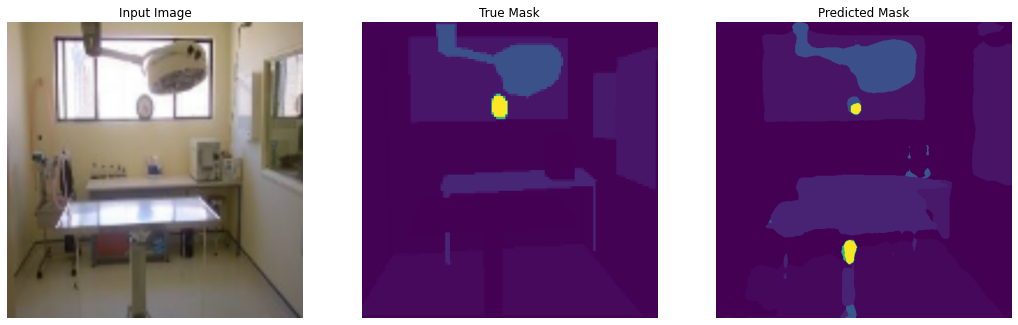

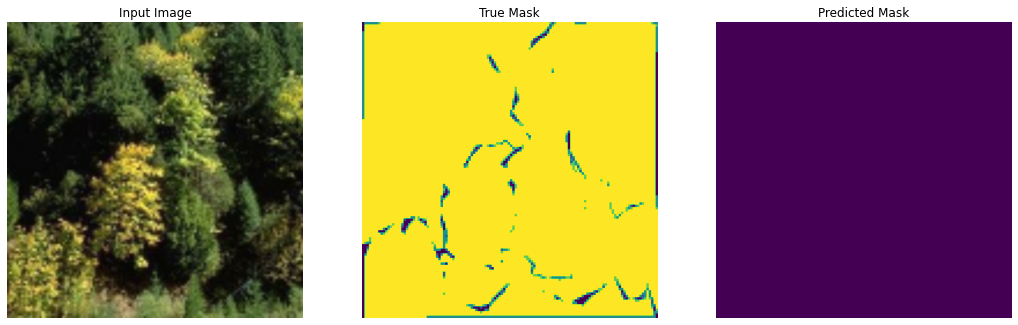

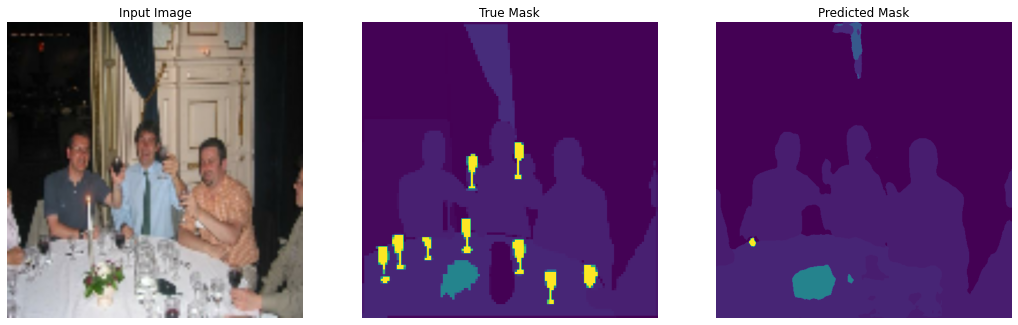

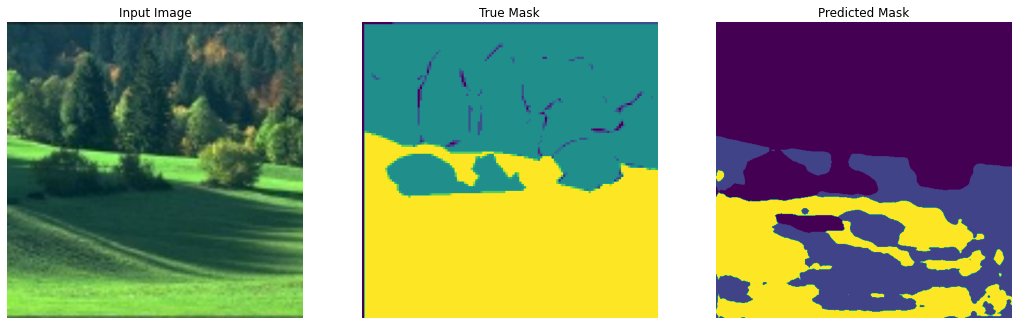

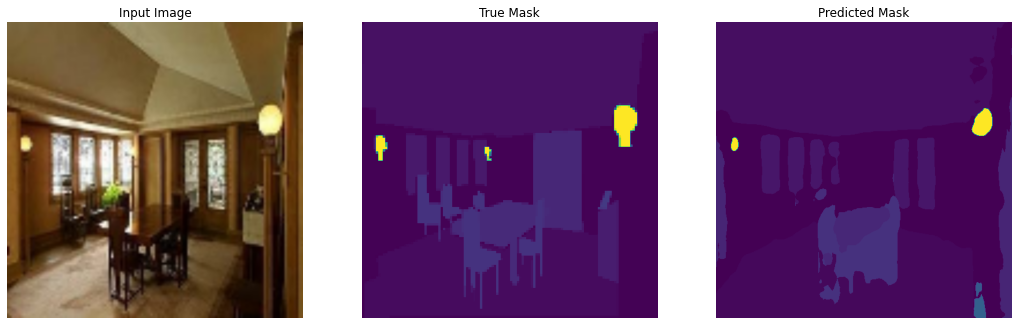

In [56]:
# for i in range(5):
#     for image, mask in dataset['train'].take(1):
#         sample_image, sample_mask = preprocess_image(image, mask)

#     show_predictions()
    
    
    
def preprocess_image(image, mask, desired_size=(512, 512)):
    # Resize image and mask
    resized_image = tf.image.resize(image, desired_size)
    resized_mask = tf.image.resize(mask, desired_size, method='nearest')  # Use nearest neighbor for the mask
    return resized_image, resized_mask


for i in range(5):
    # Extract a single sample from the dataset
    for image, mask in dataset['train'].take(1):
        sample_image, sample_mask = preprocess_image(image, mask)


    # Now use resized_image and resized_mask for predictions or further processing
    show_predictions(model=deeplabv3plus)

# Model Evaluation

In [36]:
# Metrics
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
miou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)  # Replace NUM_CLASSES with your actual number of classes

# Accumulate metrics over the validation set
for image_batch, mask_batch in dataset['val'].take(VALIDATION_STEPS):
    # Make predictions
    predictions = model.predict(image_batch)

    # Update metrics
    accuracy_metric.update_state(mask_batch, predictions)
    # For mIoU, you need to convert predictions to discrete values (e.g., using argmax)
    predicted_classes = tf.argmax(predictions, axis=-1)
    #miou_metric.update_state(mask_batch, predicted_classes)

# Get final metric results
accuracy = accuracy_metric.result().numpy()
#miou = miou_metric.result().numpy()

# Clear the state of the metrics
accuracy_metric.reset_states()
#miou_metric.reset_states()

# Print the results
print(f"Accuracy on Validation Set: {accuracy}")
#print(f"Mean IoU on Validation Set: {miou}")

Accuracy on Validation Set: 0.0037016295827925205


In [43]:
def deeplab_process_batch(images, masks=None, desired_size=(512, 512)):
    # Resize images and masks
    resized_images = tf.image.resize(images, desired_size)
    if masks!=None:
        resized_masks = tf.image.resize(masks, desired_size, method='nearest')  # Use nearest neighbor for the masks
    else:
        resized_masks = None
    return resized_images, resized_masks


# Metrics
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Accumulate metrics over the validation set
for image_batch, mask_batch in dataset['val'].take(VALIDATION_STEPS):
    image_batch, mask_batch = deeplab_process_batch(image_batch, mask_batch)
    # Make predictions
    predictions = deeplabv3plus.predict(image_batch)

    # Update metrics
    accuracy_metric.update_state(mask_batch, predictions)
    # For mIoU, you need to convert predictions to discrete values (e.g., using argmax)
    predicted_classes = tf.argmax(predictions, axis=-1)

# Get final metric results
accuracy = accuracy_metric.result().numpy()

# Clear the state of the metrics
accuracy_metric.reset_states()

# Print the results
print(f"DeepLabV3Plus Accuracy on Validation Set: {accuracy}")

DeepLabV3Plus Accuracy on Validation Set: 0.6476088762283325


In [58]:
import pandas as pd
from tqdm import tqdm


def deeplab_process_batch(images, masks=None, desired_size=(512, 512)):
    # Resize images and masks
    resized_images = tf.image.resize(images, desired_size)
    if masks is not None:
        resized_masks = tf.image.resize(masks, desired_size, method='nearest')  # Use nearest neighbor for the masks
    else:
        resized_masks = None
    return resized_images, resized_masks

# Initialize dictionary to store accuracy for each class
accuracy_per_class = {f'Class_{i}': tf.keras.metrics.Accuracy() for i in range(NUM_CLASSES)}

# Accumulate metrics over the validation set
for image_batch, mask_batch in tqdm(dataset['val'].take(VALIDATION_STEPS)):
    image_batch, mask_batch = deeplab_process_batch(image_batch, mask_batch)
    # Make predictions
    predictions = deeplabv3plus.predict(image_batch)
    predicted_classes = tf.argmax(predictions, axis=-1)

    # Update per-class accuracy
    for i in range(NUM_CLASSES):
        # Create masks for each class
        true_mask = tf.equal(mask_batch, i)
        pred_mask = tf.equal(predicted_classes, i)

        # Update accuracy for the class
        accuracy_per_class[f'Class_{i}'].update_state(true_mask, pred_mask)

# Extract the final accuracy results for each class
accuracy_results = {class_id: metric.result().numpy() for class_id, metric in accuracy_per_class.items()}

# Clear the state of the metrics
for metric in accuracy_per_class.values():
    metric.reset_states()

# Convert to pandas DataFrame for easy viewing
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=['Class', 'Accuracy'])

# Print the DataFrame
print(accuracy_df)


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [05:55<00:00,  1.12it/s]

         Class  Accuracy
0      Class_0  0.926345
1      Class_1  0.906443
2      Class_2  0.952927
3      Class_3  0.988851
4      Class_4  0.967705
..         ...       ...
145  Class_145  0.999579
146  Class_146  0.999471
147  Class_147  0.999331
148  Class_148  0.999498
149  Class_149  0.999826

[150 rows x 2 columns]


In [61]:
accuracy_df.to_excel("DeepLabV3Plus_trained_perClass_acc.xlsx")  

In [60]:
# Original:
# DeepLabV3Plus Original Accuracy on Validation Set: 0.6476088762283325

# After training:
#Epoch 00002: val_loss improved from 4.10247 to 3.73493, saving model to best_model_deeplabv3plus_trained.h5
#DeepLabV3Plus Accuracy on Validation Set: 0.6090981960296631
!pip install openpyxl